# Churn Prediction EDA

In [50]:
# Importar las librerías necesarias
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

Importar y organizar dataset

In [51]:
# Importar dataset
df = pd.read_csv('churn_prediction_features.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5293 entries, 0 to 5292
Columns: 112 entries, order_count_3m to customer_id
dtypes: float64(98), int64(14)
memory usage: 4.5 MB


Determinar cuáles columnas son numéricas o categóricas


In [52]:
# Categóricas, teniendo en cuenta que las categóricas empiezan con 'sub_categoria_' or 'warehouse_'
categorical_cols = [col for col in df.columns if col.startswith('sub_categoria_') or col.startswith('warehouse_')]
# Incluir manualmente más columnas categóricas
categorical_cols.extend(['customer_id', 'has_churned_before', 'is_churned'])
# Numéricas
numerical_cols = [col for col in df.columns if col not in categorical_cols]

## Reducción de dimensionalidad

Se hará una reducción de dimensionalidad con base en la prueba chi-cuadrado. El objetivo principal es identificar y retener solo aquellas variables categóricas que son estadísticamente independientes entre sí.

Esto se hace utilizando una prueba chi-cuadrado, donde se considera que dos variables son independientes si el valor p de la prueba es mayor que 0.05 (umbral común para significancia estadística).

### Variables Categóricas

Verificar la dimensión del dataframe de variables categóricas

In [53]:
df_categoricals = df[categorical_cols].drop(columns=['customer_id'], axis = 1)
df_categoricals.shape

(5293, 83)

En total hay 83 columnas categóricas. Se realizarán pruebas de independecia en estas 83 columnas categóricas. 

### Verificando supuestos de la prueba chi cuadrado

Uno de los supuestos indica que debe haber almenos cinco ocurrencias de cada clase para cada variable categórica.  Se verificará que cada variable categórica cumpla con este supuesto.

In [54]:
# Crear un DataFrame vacío para almacenar los conteos de valores
value_counts_df = pd.DataFrame(index=['negative_class', 'positive_class'])

# Iterar a través de cada columna categórica y obtener los conteos de valores
for column in df_categoricals.columns:
    value_counts = df_categoricals[column].value_counts().values
    value_counts_df[column] = value_counts

# Mostrar el DataFrame resultante
value_counts_df.T


,negative_class,positive_class
sub_categoria_Accesorios,5111,180
sub_categoria_Acondicionador,4434,857
sub_categoria_Ambientadores,5271,20
sub_categoria_Analgésicos,4646,645
sub_categoria_Antibióticos y analgésicos,5012,279
...,...,...
sub_categoria_sin info,3942,1349
warehouse_Barranquilla,3543,1748
warehouse_Bogota,3568,1723
has_churned_before,3575,1718


Determinar categorías con menos de 5 registros en la clase negativa:

In [55]:
value_counts_df.T[value_counts_df.T['negative_class'] < 5]

,negative_class,positive_class


Determinar categorías con menos de 5 registros en la clase positiva:

In [56]:
value_counts_df.T[value_counts_df.T['positive_class'] < 5]

,negative_class,positive_class
sub_categoria_Detergentes y jabones,5290,1


En la clase negativa no resultó ninguna categoría, pero en la positiva se tiene "sub_categoria_Detergentes y jabones". Se procederá a excluir esta categoría de la prueba. 

In [57]:
df_categoricals = df_categoricals.drop(columns=['sub_categoria_Detergentes y jabones'], axis=1)

#### Aplicar prueba chi cuadrado

Se procede a hacer pruebas chi cuadrado entre todas las posibles combinaciones de columnas categóricas que quedaron, y se guarda este resultado en un nuevo dataframe. 

Esta prueba es útil para evaluar la independencia estadística entre pares de variables categóricas en un conjunto de datos.

In [58]:
# Crear un DataFrame vacío para almacenar los valores p
p_values_df = pd.DataFrame(index=df_categoricals.columns, columns=df_categoricals.columns)

# Iterar a través de cada par de columnas categóricas para realizar la prueba chi-cuadrado
for col1 in df_categoricals.columns:
    for col2 in df_categoricals.columns:
         # Crear una tabla de contingencia entre las dos columnas
        contingency_table = pd.crosstab(df_categoricals[col1], df_categoricals[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values_df.at[col1, col2] = p_value

# Mostrar el DataFrame resultante con los valores p
p_values_df

,sub_categoria_Accesorios,sub_categoria_Acondicionador,sub_categoria_Ambientadores,sub_categoria_Analgésicos,sub_categoria_Antibióticos y analgésicos,sub_categoria_Anticonceptivos,sub_categoria_Antidiarreicos y sueros,sub_categoria_Antimicótico - Anti hongos,sub_categoria_Antimicótico íntimo,sub_categoria_Antipruriginoso - Anti picazon,...,sub_categoria_Tos,sub_categoria_Tratamiento cicatrices y heridas,sub_categoria_Uñas,sub_categoria_Vendas,sub_categoria_Vitaminas,sub_categoria_sin info,warehouse_Barranquilla,warehouse_Bogota,has_churned_before,is_churned
sub_categoria_Accesorios,0.0,0.0,0.0,0.0,0.0,0.0,0.000364,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000014,0.000024,0.000622,0.0
sub_categoria_Acondicionador,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.168168,0.165402,0.000207,0.0
sub_categoria_Ambientadores,0.0,0.000001,0.0,0.0,0.0,0.024807,0.743419,0.000111,0.000042,0.0,...,1.0,0.101193,0.017297,0.0,0.021555,0.000016,0.959184,0.995062,0.627648,0.087468
sub_categoria_Analgésicos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000418,0.0
sub_categoria_Antibióticos y analgésicos,0.0,0.0,0.0,0.0,0.0,0.0,0.000021,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000011,0.000012,0.025377,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub_categoria_sin info,0.0,0.0,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
warehouse_Barranquilla,0.000014,0.168168,0.959184,0.0,0.000011,0.078546,0.003716,0.0,0.0,0.0,...,0.000217,0.0,0.002479,0.000024,0.0,0.0,0.0,0.0,0.0,0.0
warehouse_Bogota,0.000024,0.165402,0.995062,0.0,0.000012,0.155511,0.007535,0.0,0.0,0.0,...,0.000442,0.0,0.000863,0.000117,0.0,0.0,0.0,0.0,0.0,0.0
has_churned_before,0.000622,0.000207,0.627648,0.000418,0.025377,0.0,0.0,0.0,0.002244,0.032738,...,0.000916,0.000051,0.0,0.016002,0.0,0.0,0.0,0.0,0.0,0.001787


**Proceso de descarte**

Ahora incia un proceso de selección de variables categóricas basado en la independencia estadística. Se empienzan a descartar todas las que son dependientes. 

Se incia el proceso con todas aquellas que son dependientes a warehouse_Bogota (escogida aleatoriamente entre todas las variables)

In [59]:
# Crear una lista de columnas independientes basada en los valores p con respecto a 'warehouse_Bogota'
independent_columns = list(p_values_df[p_values_df['warehouse_Bogota'] > 0.05].index)
# Añadir 'warehouse_Bogota' a la lista de columnas independientes
independent_columns.extend(['warehouse_Bogota'])
# Crear un nuevo DataFrame que solo contenga las columnas independientes identificadas
df_independent_variables = df_categoricals[independent_columns]
# Mostrar el DataFrame resultante con las variables independientes
df_independent_variables

,sub_categoria_Acondicionador,sub_categoria_Ambientadores,sub_categoria_Anticonceptivos,sub_categoria_Complementos y vitaminas,sub_categoria_Cuidado corporal,sub_categoria_Cuidado de los pies,sub_categoria_Cuidado facial,sub_categoria_Gomas,sub_categoria_Naturales,sub_categoria_Productos para rehabilitación,sub_categoria_Proteccion e higiene íntima femenina,warehouse_Bogota
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5288,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
5289,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
5290,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
5291,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


El resultado evidencia que 12 columnas son independientes a la columna warehouse_Bogota. Se procederá a utilizar otra columna aleatoria para verificar nuevamente independecia y descartar las dependientes. 

Para este proceso se repite la prueba de chi-cuadrado

**Repetir prueba chi-cuadrado**

In [60]:
# Crear un DataFrame vacío para almacenar los valores p
p_values_df = pd.DataFrame(index=df_independent_variables.columns, columns=df_independent_variables.columns)

# Recorrer cada par de columnas categóricas y realizar la prueba de chi-cuadrado
for col1 in df_independent_variables.columns:
    for col2 in df_independent_variables.columns:
        contingency_table = pd.crosstab(df_independent_variables[col1], df_independent_variables[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values_df.at[col1, col2] = p_value

# Mostrar el DataFrame resultante con los valores p
p_values_df

,sub_categoria_Acondicionador,sub_categoria_Ambientadores,sub_categoria_Anticonceptivos,sub_categoria_Complementos y vitaminas,sub_categoria_Cuidado corporal,sub_categoria_Cuidado de los pies,sub_categoria_Cuidado facial,sub_categoria_Gomas,sub_categoria_Naturales,sub_categoria_Productos para rehabilitación,sub_categoria_Proteccion e higiene íntima femenina,warehouse_Bogota
sub_categoria_Acondicionador,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165402
sub_categoria_Ambientadores,0.000001,0.0,0.024807,0.414167,0.007176,0.000018,0.000031,0.000398,0.000001,1.0,0.000025,0.995062
sub_categoria_Anticonceptivos,0.0,0.024807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155511
sub_categoria_Complementos y vitaminas,0.0,0.414167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115869
sub_categoria_Cuidado corporal,0.0,0.007176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081005
sub_categoria_Cuidado de los pies,0.0,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126449
sub_categoria_Cuidado facial,0.0,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343994
sub_categoria_Gomas,0.0,0.000398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.720619
sub_categoria_Naturales,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968453
sub_categoria_Productos para rehabilitación,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383006


**Repetir proceso de descarte**

Después de repetir la prueba de chi-cuadrado se continúa nuevamente con el proceso de descarte. Se repetirá el proceso hasta que las variables sean independientes.

En esta ocasión se selecciona aleatoriamente la variable 'sub_categoria_Ambientadores'. Se eliminarán las variables dependientes a esta.

In [61]:
# Crear una lista de columnas independientes basadas en un valor p umbral
independent_columns =  list(p_values_df[p_values_df['sub_categoria_Ambientadores'] > 0.05].index)
# Agregar la columna 'sub_categoria_Ambientadores' a la lista de columnas independientes
independent_columns.extend(['sub_categoria_Ambientadores'])
# Filtrar el DataFrame original df_independent_variables para incluir solo las columnas independientes
df_independent_variables = df_independent_variables[independent_columns]
# Mostrar el DataFrame resultante con las variables independientes
df_independent_variables

,sub_categoria_Complementos y vitaminas,sub_categoria_Productos para rehabilitación,warehouse_Bogota,sub_categoria_Ambientadores
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
5288,0.0,0.0,1.0,0.0
5289,0.0,1.0,1.0,0.0
5290,1.0,1.0,1.0,0.0
5291,1.0,0.0,1.0,0.0


In [62]:
# Repetir prueba 
# Crear un DataFrame vacío para almacenar los valores p
p_values_df = pd.DataFrame(index=df_independent_variables.columns, columns=df_independent_variables.columns)

# Recorrer cada par de columnas categóricas y realizar la prueba de chi-cuadrado
for col1 in df_independent_variables.columns:
    for col2 in df_independent_variables.columns:
        contingency_table = pd.crosstab(df_independent_variables[col1], df_independent_variables[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values_df.at[col1, col2] = p_value

# Mostrar el DataFrame resultante con los valores p
p_values_df

,sub_categoria_Complementos y vitaminas,sub_categoria_Productos para rehabilitación,warehouse_Bogota,sub_categoria_Ambientadores
sub_categoria_Complementos y vitaminas,0.0,0.0,0.115869,0.414167
sub_categoria_Productos para rehabilitación,0.0,0.0,0.383006,1.0
warehouse_Bogota,0.115869,0.383006,0.0,0.995062
sub_categoria_Ambientadores,0.414167,1.0,0.995062,0.0


Después de reptir el proceso, quedan 4 variables. Se procederá a repetir.

In [63]:
# Crear una lista de columnas independientes basadas en un valor p umbral
independent_columns = list(p_values_df[p_values_df['sub_categoria_Complementos y vitaminas'] > 0.05].index)
# Agregar la columna 'sub_categoria_Complementos y vitaminas' a la lista de columnas independientes
independent_columns.extend(['sub_categoria_Complementos y vitaminas'])
# Filtrar el DataFrame original df_independent_variables para incluir solo las columnas independientes
df_independent_variables = df_independent_variables[independent_columns]
# Mostrar el DataFrame resultante con las variables independientes
df_independent_variables

,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
5288,1.0,0.0,0.0
5289,1.0,0.0,0.0
5290,1.0,0.0,1.0
5291,1.0,0.0,1.0


In [64]:
# Repetir prueba
# Crear un DataFrame vacío para almacenar los valores p
p_values_df = pd.DataFrame(index=df_independent_variables.columns, columns=df_independent_variables.columns)

# Recorrer cada par de columnas categóricas y realizar la prueba de chi-cuadrado
for col1 in df_independent_variables.columns:
    for col2 in df_independent_variables.columns:
        contingency_table = pd.crosstab(df_independent_variables[col1], df_independent_variables[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values_df.at[col1, col2] = p_value

# Mostrar el DataFrame resultante con los valores p
p_values_df

,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas
warehouse_Bogota,0.0,0.995062,0.115869
sub_categoria_Ambientadores,0.995062,0.0,0.414167
sub_categoria_Complementos y vitaminas,0.115869,0.414167,0.0


En este ultimo caso las tres variables restantes son indpendientes. Ahora se procede a utilizar estas 3 variables para el modelo.

In [65]:
# Filtrar las 3 columnas independientes en el dataframe original.
df_categoricals = df_categoricals[['warehouse_Bogota', 'sub_categoria_Ambientadores', 'sub_categoria_Complementos y vitaminas']]

### Variables numéricas

Para las variables numéricas se realiza una matrix de correlación

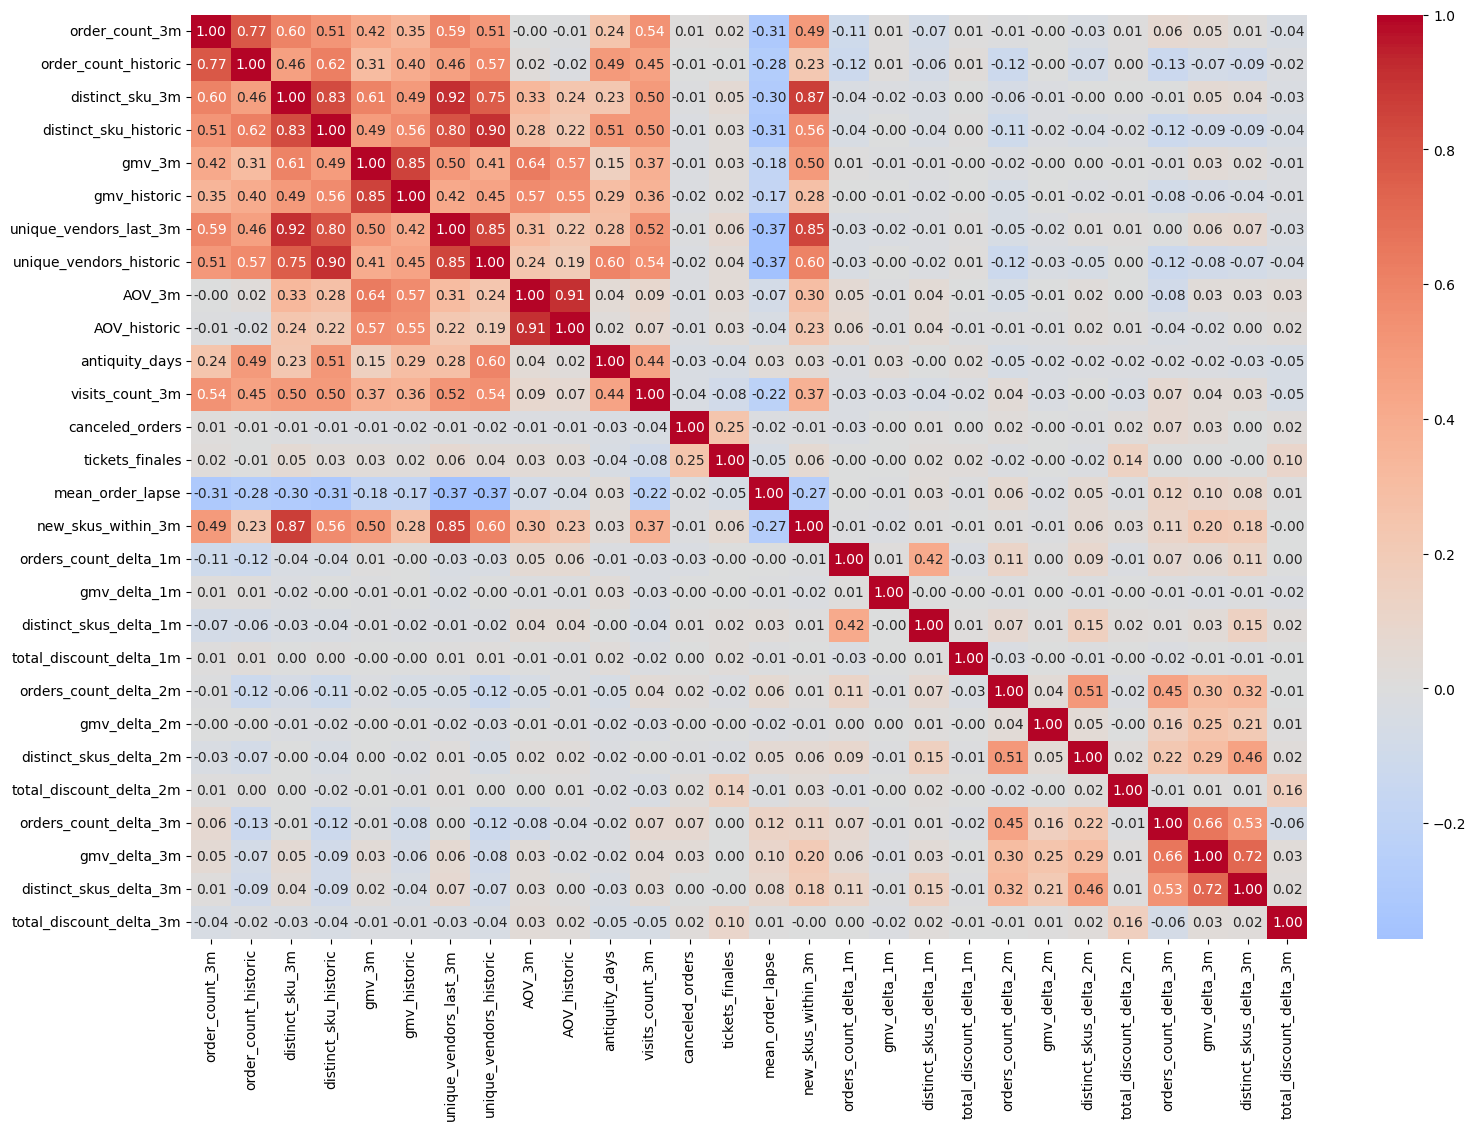

In [66]:
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, center=0, cmap='coolwarm', fmt=".2f")
plt.show()

Se evidencia que existen variables con correlaciones altas. Estas se eliminarán con el Variance Inflation Factor. 

Antes de este proceso, se deben revisar los datos faltantes. 

### Datos faltantes

In [67]:
# Se filtran las columnas con las variables numericas, las variables indpendientes y la variable objetivo
df_reduction = df[numerical_cols + independent_columns].copy()
df_reduction

,order_count_3m,order_count_historic,distinct_sku_3m,distinct_sku_historic,gmv_3m,gmv_historic,unique_vendors_last_3m,unique_vendors_historic,AOV_3m,AOV_historic,...,gmv_delta_2m,distinct_skus_delta_2m,total_discount_delta_2m,orders_count_delta_3m,gmv_delta_3m,distinct_skus_delta_3m,total_discount_delta_3m,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas
0,1,1,8,8,1.503600e+05,1.503600e+05,1,1,1.503600e+05,1.503600e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
1,1,1,5,5,1.127700e+05,1.127700e+05,1,1,1.127700e+05,1.127700e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
2,1,1,4,4,1.452720e+05,1.452720e+05,1,1,1.452720e+05,1.452720e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
3,1,1,11,11,2.014311e+05,2.014311e+05,7,7,2.014311e+05,2.014311e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
4,1,1,6,6,1.612760e+05,1.612760e+05,6,6,1.612760e+05,1.612760e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5288,97,517,270,629,1.769209e+07,7.735332e+07,63,83,1.823927e+05,1.496196e+05,...,0.227910,0.087963,0.127732,0.000000,0.220285,0.084677,0.514818,1.0,0.0,0.0
5289,98,170,968,1377,8.489914e+07,2.313428e+08,111,124,8.663178e+05,1.360840e+06,...,0.461090,0.252427,0.018004,2.769231,0.572470,0.690559,0.054177,1.0,0.0,0.0
5290,100,292,761,1259,1.560360e+08,6.530394e+08,95,112,1.560360e+06,2.236436e+06,...,1.105045,0.457831,0.033094,0.000000,-0.108634,0.006631,0.157169,1.0,0.0,1.0
5291,124,646,263,705,9.956271e+06,4.785726e+07,64,94,8.029251e+04,7.408244e+04,...,-0.113606,-0.153527,0.927276,-0.192547,-0.003659,-0.018116,0.772205,1.0,0.0,1.0


Se evidencia la presencia de valores faltantes en el dataframe. Se procederá a visualizarlos. 

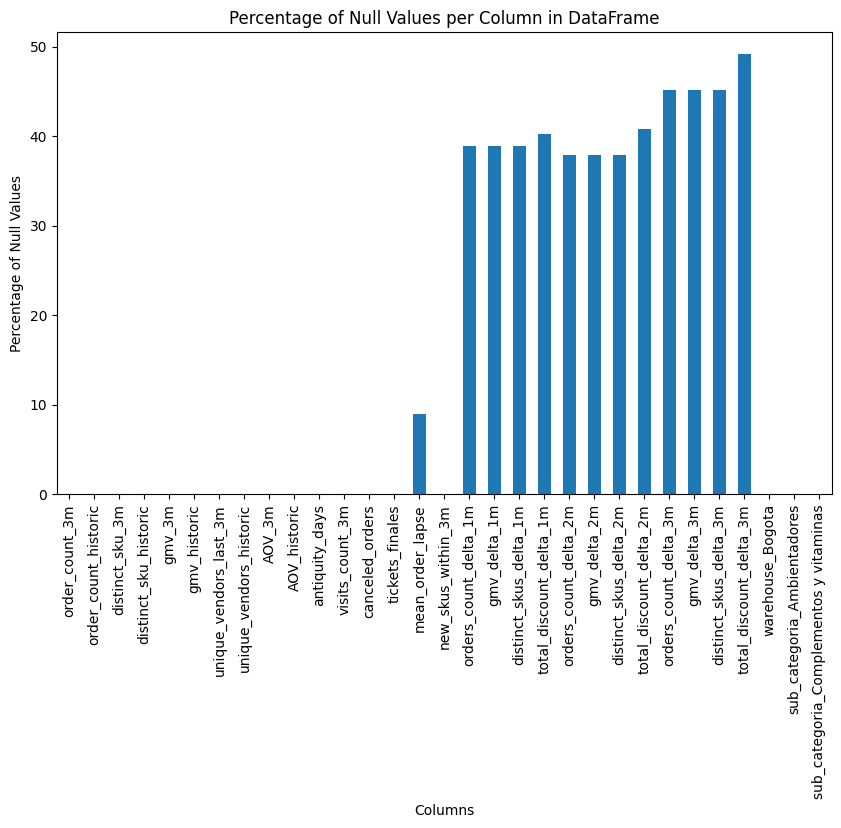

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcular el porcentaje de valores nulos
null_percent = df_reduction.isnull().mean() * 100
# Visualizar
plt.figure(figsize=(10, 6))
null_percent.plot.bar()
plt.ylabel('Percentage of Null Values')
plt.xlabel('Columns')
plt.title('Percentage of Null Values per Column in DataFrame')
plt.show()

Se evidencia que hay varias columnas con más del 40% de valores nulos. Se procede a eliminar estas columnas e imputar los datos faltantaes en las demás.

In [69]:
# Se eliminan columnas con 40% o más de datos faltantes
threshold = 0.6 * len(df_reduction)
df_reduction = df_reduction.dropna(thresh=threshold, axis=1)

# imputando datos con IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=50, random_state=0)

imputed_data = imputer.fit_transform(df_reduction)

imputed_df = pd.DataFrame(imputed_data, columns=df_reduction.columns)

df_reduction = imputed_df.copy()

df_reduction.isna().sum()

order_count_3m                            0
order_count_historic                      0
distinct_sku_3m                           0
distinct_sku_historic                     0
gmv_3m                                    0
gmv_historic                              0
unique_vendors_last_3m                    0
unique_vendors_historic                   0
AOV_3m                                    0
AOV_historic                              0
antiquity_days                            0
visits_count_3m                           0
canceled_orders                           0
tickets_finales                           0
mean_order_lapse                          0
new_skus_within_3m                        0
orders_count_delta_1m                     0
gmv_delta_1m                              0
distinct_skus_delta_1m                    0
orders_count_delta_2m                     0
gmv_delta_2m                              0
distinct_skus_delta_2m                    0
warehouse_Bogota                

### Eliminar multicolinealidad con Variance Inflation Factor (VIF)

Recordemos que:

- Un VIF ≥ 5 indica alta multicolinealidad entre la correspondiente variable independiente y las demás variables.

- Recomendación: Eliminar una columna a la vez. Aquella con el máximo VIF ≥ 5. Luego, para el nuevo dataframe, calcular nuevamente VIF e identificar nuevas columnas con VIF ≥ 5 máximo, y así sucesivamente hasta obtener solo valores de VIF < 5.

- Según corresponda, variables categóricas deben previamente codificarse usando por ejemplo OneHotEncoder().

In [70]:
vif_data = pd.DataFrame()
vif_data["Variable"] = df_reduction.columns
vif_data["VIF"] = [variance_inflation_factor(df_reduction.values, i) for i in range(df_reduction.shape[1])]

# Mostrar los resultados
print(vif_data)

                                  Variable        VIF
0                           order_count_3m   8.689462
1                     order_count_historic   7.071149
2                          distinct_sku_3m  43.065298
3                    distinct_sku_historic  32.620615
4                                   gmv_3m   9.101740
5                             gmv_historic   7.413111
6                   unique_vendors_last_3m  40.503112
7                  unique_vendors_historic  54.064771
8                                   AOV_3m  12.851760
9                             AOV_historic  10.828574
10                          antiquity_days   8.954980
11                         visits_count_3m   3.974091
12                         canceled_orders   1.086600
13                         tickets_finales   1.116142
14                        mean_order_lapse   1.937464
15                      new_skus_within_3m  15.590733
16                   orders_count_delta_1m   1.556624
17                          

En este caso se eliminan las columnas con un VIF mayor que 5, eliminando la de mayor VIF en cada iteración. 

In [71]:
while True:
    # Calcular el Factor de Inflación de la Varianza (VIF) para cada variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df_reduction.columns
    vif_data["VIF"] = [variance_inflation_factor(df_reduction.values, i) for i in range(df_reduction.shape[1])]

    # Comprobar si el VIF máximo está por encima del umbral (5)
    max_vif = vif_data["VIF"].max()
    if max_vif < 5:
        break

    # Identificar la variable/columna con el VIF más alto
    max_vif_variable = vif_data.sort_values("VIF", ascending=False).iloc[0]
    variable_name = max_vif_variable["Variable"]

    # Imprimir la variable que se va a eliminar y su VIF
    print(f"Eliminando '{variable_name}' con VIF: {max_vif}")

    # Eliminar la variable/columna del DataFrame
    df_reduction = df_reduction.drop(columns=[variable_name], axis=1)

Eliminando 'unique_vendors_historic' con VIF: 54.064770957302436
Eliminando 'distinct_sku_3m' con VIF: 28.301055802923763
Eliminando 'unique_vendors_last_3m' con VIF: 19.750538287298127
Eliminando 'AOV_3m' con VIF: 11.58528785671016
Eliminando 'order_count_3m' con VIF: 7.454986523068702
Eliminando 'gmv_3m' con VIF: 6.999537999734301
Eliminando 'distinct_sku_historic' con VIF: 6.1489608804132185


Se procede a verificar los resultados después de eliminar las variables alta multicolinealidad

In [87]:
# Crear un DataFrame vacío para almacenar los resultados del VIF
vif_data = pd.DataFrame()
# Agregar la columna 'Variable' al DataFrame vif_data y asignarle los nombres de las columnas de df_reduction
vif_data["Variable"] = df_reduction.columns
# Calcular el VIF para cada variable y almacenar los resultados en la columna 'VIF'
vif_data["VIF"] = [variance_inflation_factor(df_reduction.values, i) for i in range(df_reduction.shape[1])]

# Mostrar el resultado que contiene las variables y sus respectivos VIF
print(vif_data)

                                  Variable       VIF
0                     order_count_historic  2.549589
1                             gmv_historic  2.290194
2                             AOV_historic  2.226552
3                           antiquity_days  4.017303
4                          visits_count_3m  3.508315
5                          canceled_orders  1.084789
6                          tickets_finales  1.103717
7                         mean_order_lapse  1.736261
8                       new_skus_within_3m  2.135510
9                    orders_count_delta_1m  1.410192
10                            gmv_delta_1m  1.002258
11                  distinct_skus_delta_1m  1.319025
12                   orders_count_delta_2m  1.570232
13                            gmv_delta_2m  1.003790
14                  distinct_skus_delta_2m  1.456130
15                        warehouse_Bogota  2.025948
16             sub_categoria_Ambientadores  1.012302
17  sub_categoria_Complementos y vitaminas  1.

Se evidencia que quedan 17 variables y todas tienen VIF menor a 5. 
Este dataframe, agregando la columna de la variable de interés, será utilizado para entregar el modelo de clasificación.

In [88]:
# Agregar columna 'is_churned' del dataframe original
df_reduction['is_churned'] = df['is_churned']
df_reduction.head()

,order_count_historic,gmv_historic,AOV_historic,antiquity_days,visits_count_3m,canceled_orders,tickets_finales,mean_order_lapse,new_skus_within_3m,orders_count_delta_1m,gmv_delta_1m,distinct_skus_delta_1m,orders_count_delta_2m,gmv_delta_2m,distinct_skus_delta_2m,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas,is_churned
0,1,150360.000000,150360.000000,0,0,0,0,17.095455,8,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,1
1,1,112770.000000,112770.000000,0,0,0,0,17.095455,5,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,0
2,1,145272.000000,145272.000000,0,0,0,0,17.095455,4,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,1
3,1,201431.050293,201431.050293,0,0,0,0,17.095455,11,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,1
4,1,161276.000000,161276.000000,0,0,0,0,17.095455,6,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,1


Ahora que se tiene el Dataframe completo se realiza una breve descripción de cada una de las variables para comprender los psoteriores análisis exlporatorios

## Análisis con variable objetivo

Ahora que el dataframe y las variables están definidas y explicadas, se procede a realizar un análisis de las disrtibuciones de las variables teniendo en cuenta la variable objetivo o de interés. 

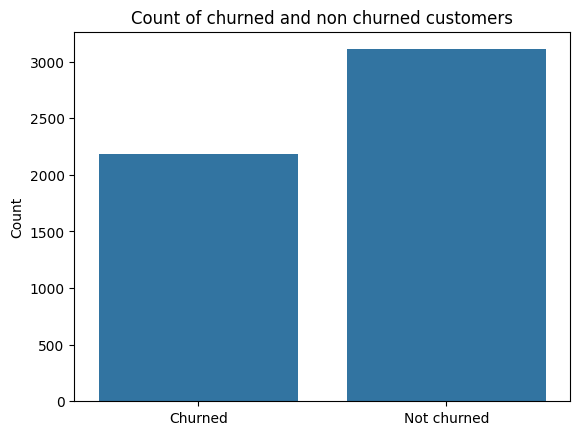

In [89]:
# Crear un gráfico de barras que cuenta los valores de 'is_churned' y reemplaza los valores 0 y 1 con etiquetas
sns.countplot(x=df_reduction['is_churned'].replace({0: 'Not churned', 1: 'Churned'}))
plt.title(f'Count of churned and non churned customers')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

Se evidencia que hay un desbalance notable en las clases de la variable objetivo

### Variables numéricas vs is_churned

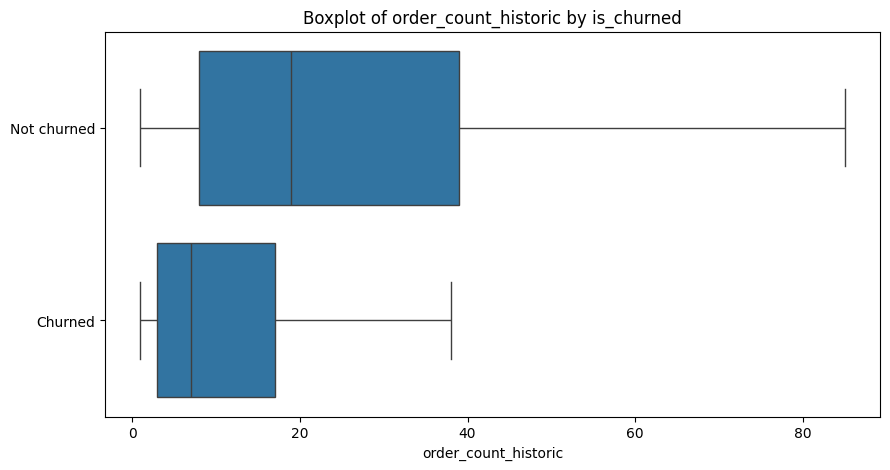

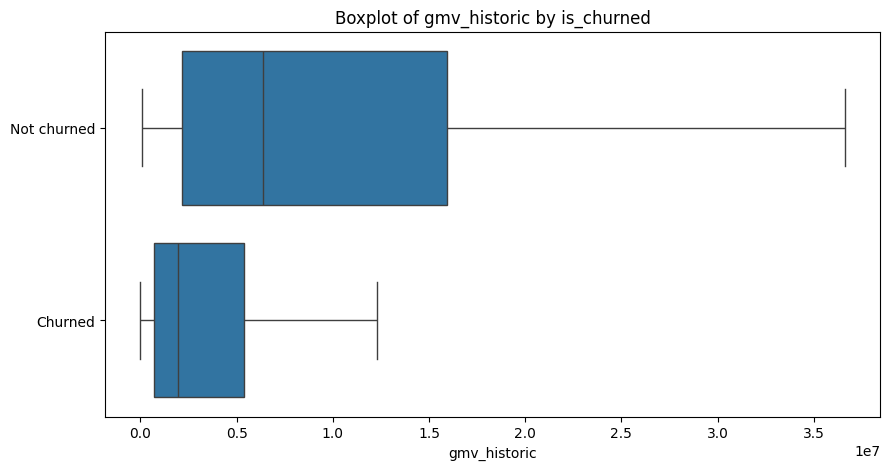

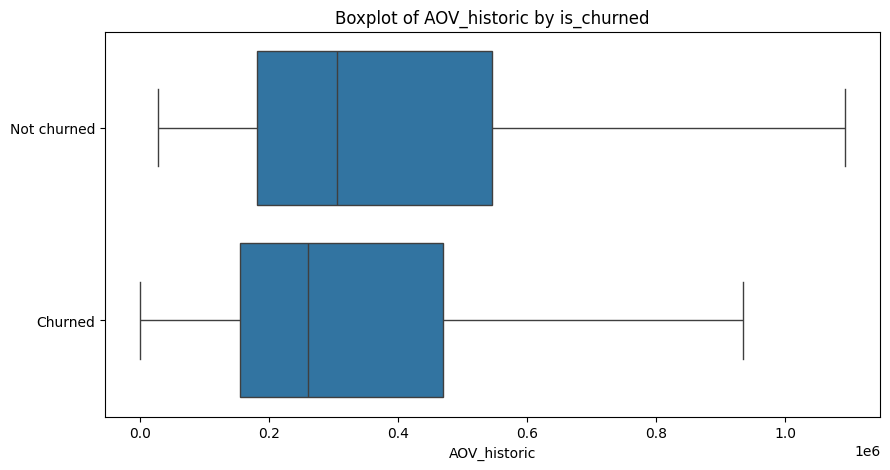

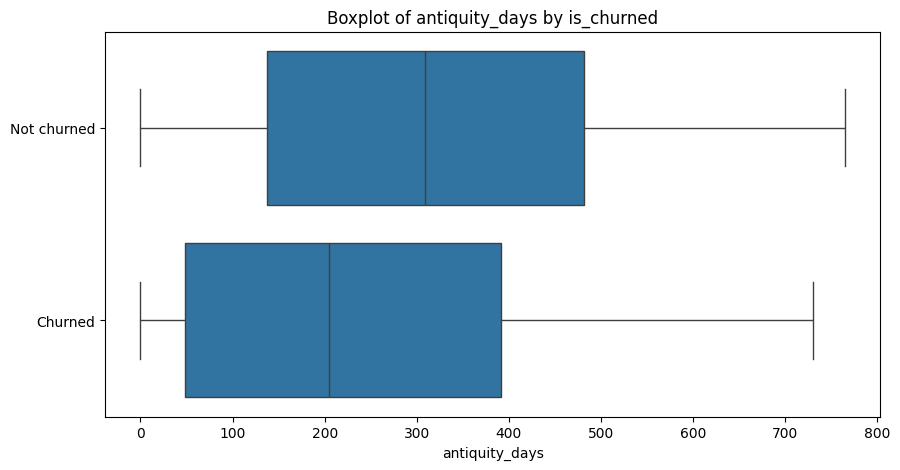

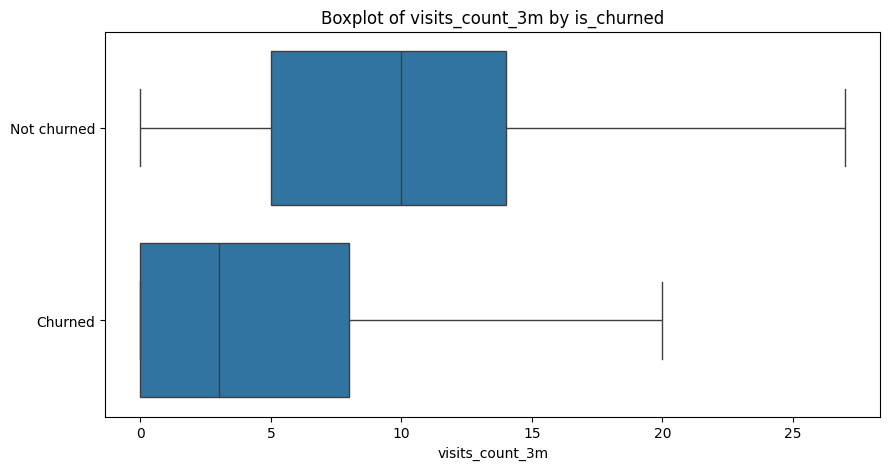

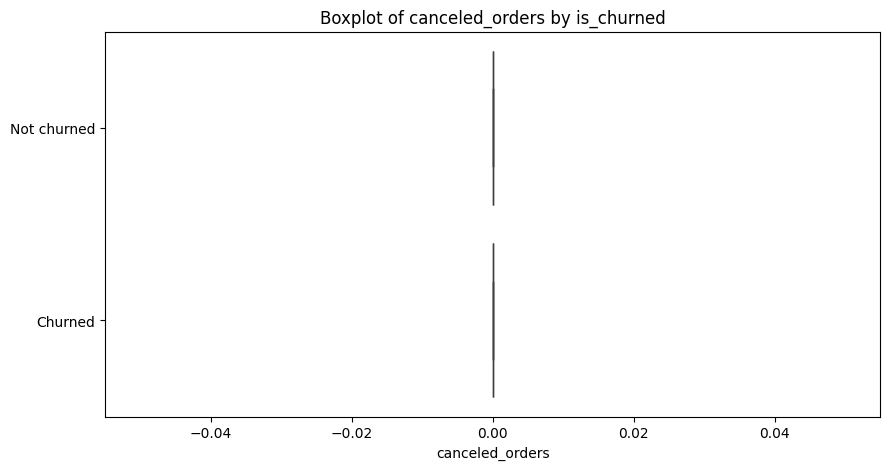

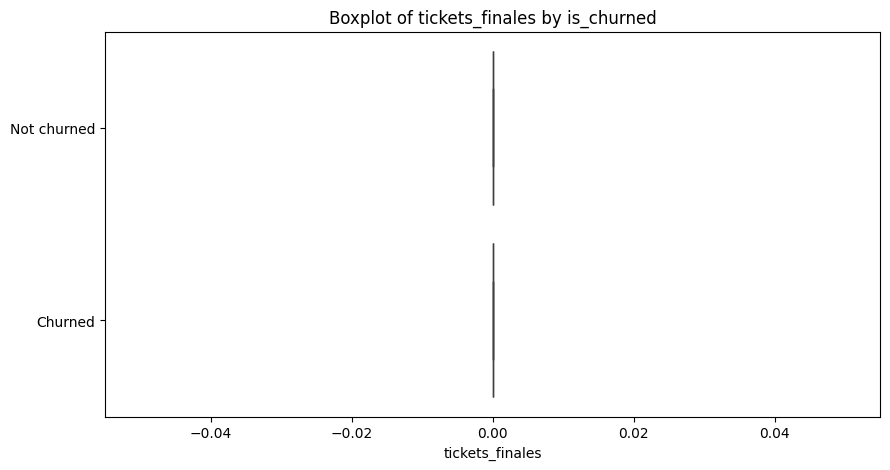

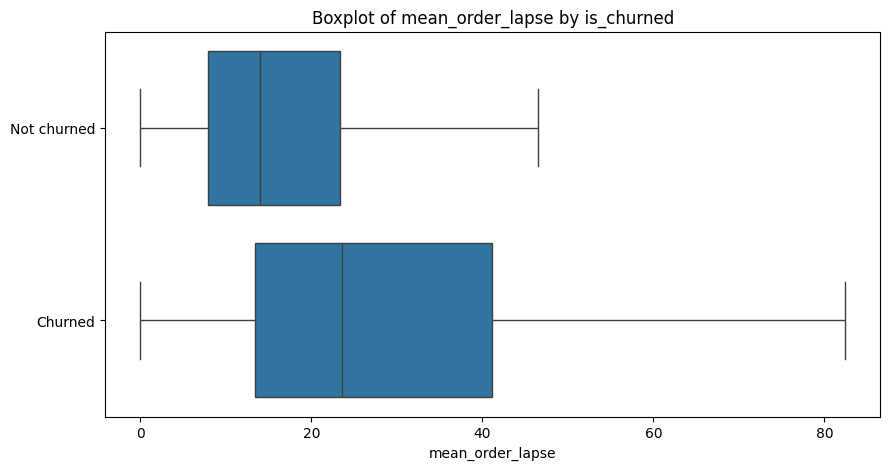

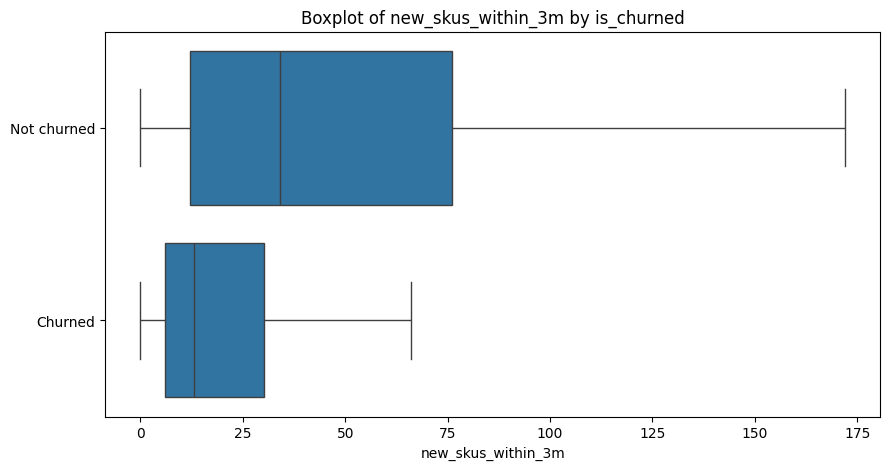

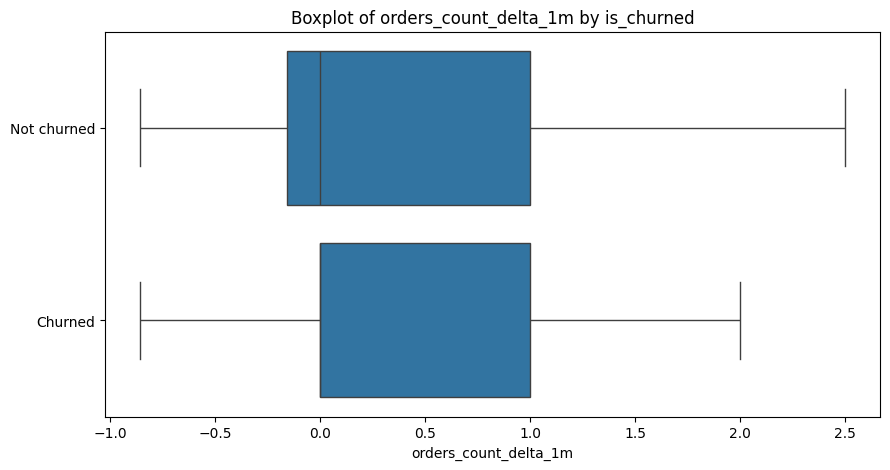

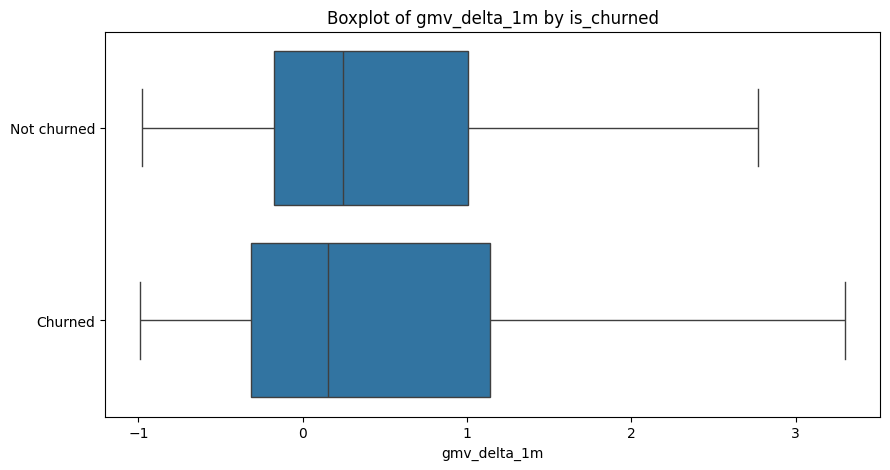

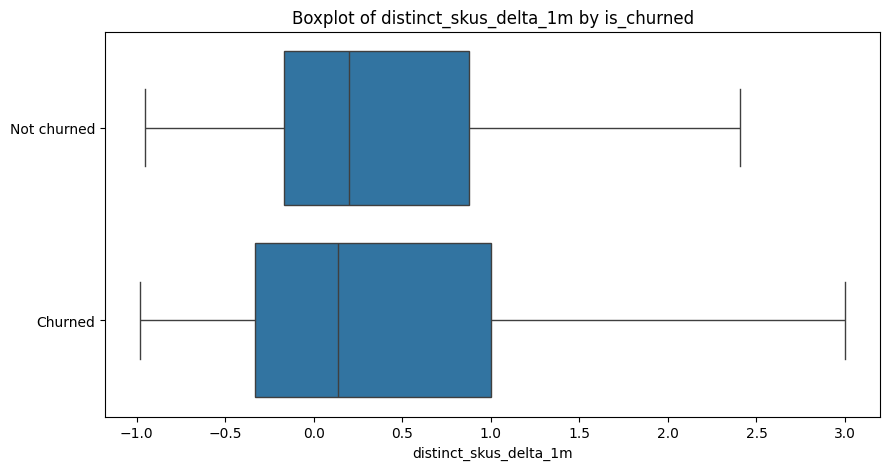

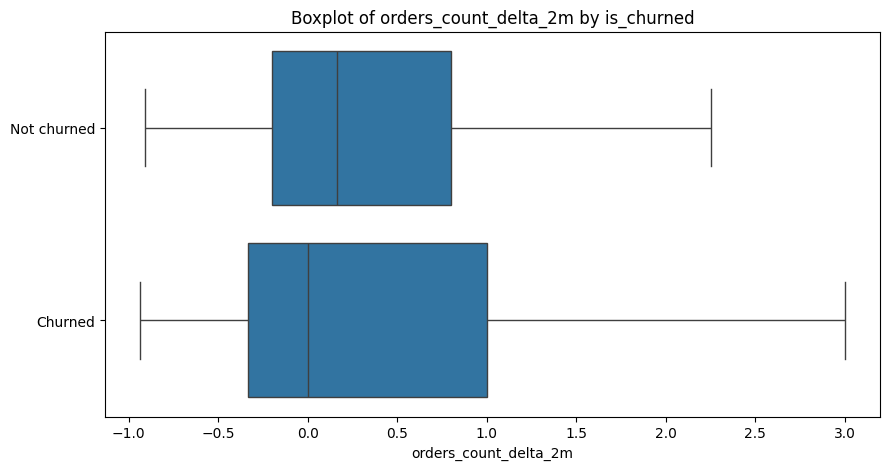

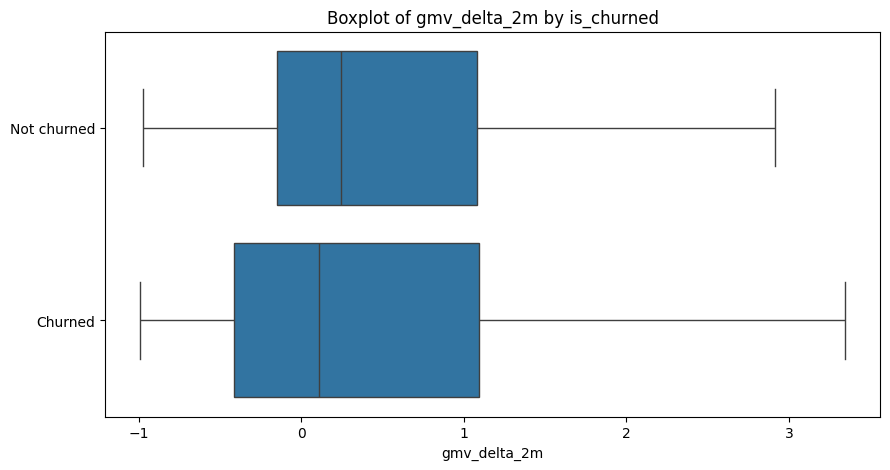

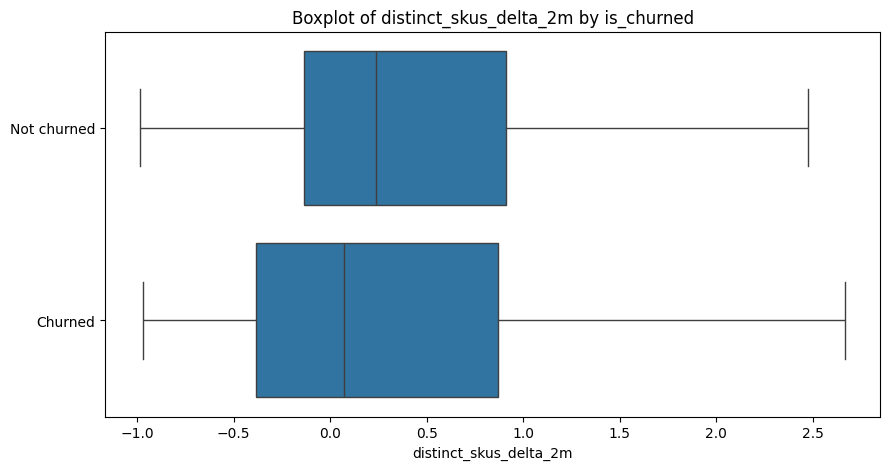

In [97]:
# Extraer columnas numéricas
numerical_cols = df_reduction.drop(columns=['warehouse_Bogota', 'sub_categoria_Ambientadores', 'sub_categoria_Complementos y vitaminas', 'is_churned']).columns.tolist()

# Crear un boxplot para cada columna numérica en función de 'is_churned'
for col in numerical_cols:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x=col, y="is_churned", data=df, orient="h", showfliers=False)
    ax.set(yticklabels=['Not churned', 'Churned'])
    ax.set(ylabel="")
    plt.title(f'Boxplot of {col} by is_churned')
    plt.show()

Interpretaciones:

- Se evidencia que hay variables cuya dispersión es significativamente distinta en cada clase de la variable 'is_churned', como es el caso de 'new_skus_within_3m', 'mean_order_lapse' y 'visit_count_3m'.

- Hay variables cuyos valores son cero en su gran mayoría, y los valores distintos a cero, son considerados atípicos (los datos atípicos están omitidos en estos boxplot, por eso no se ve nada distinto a cero) . Este es el caso de 'tickets_finales' y 'canceled_orders', lo cuál quiere decir que la gran mayoría de clientes nunca ha contactado a servicio al cliente, ni ha cancelado una órden. Pero las pocas veces que esto se da, puede ser un claro indicio que el cliente está en riesgo de abandonar la compañía

- Hay otras variables cuya dispersión en ambas clases de la variable objetivo parece ser bastante parecida, tales como lo son 'AOV' y casi todas las variables que calculan un 'Delta'

- Se puede ver también que en general, los clientes no churn tienden a tener mayor antiguedad que aquellos que sí son churn, lo cuál podría sonar intuitivo pero que al final es contrastado con la información.



### Variables categóricas vs is_churned

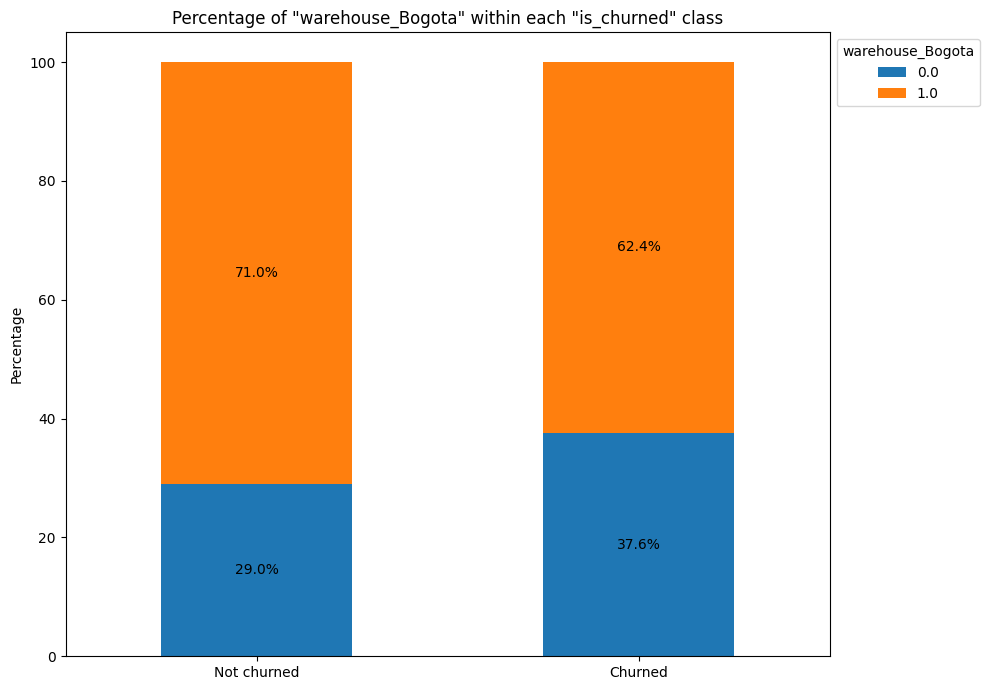

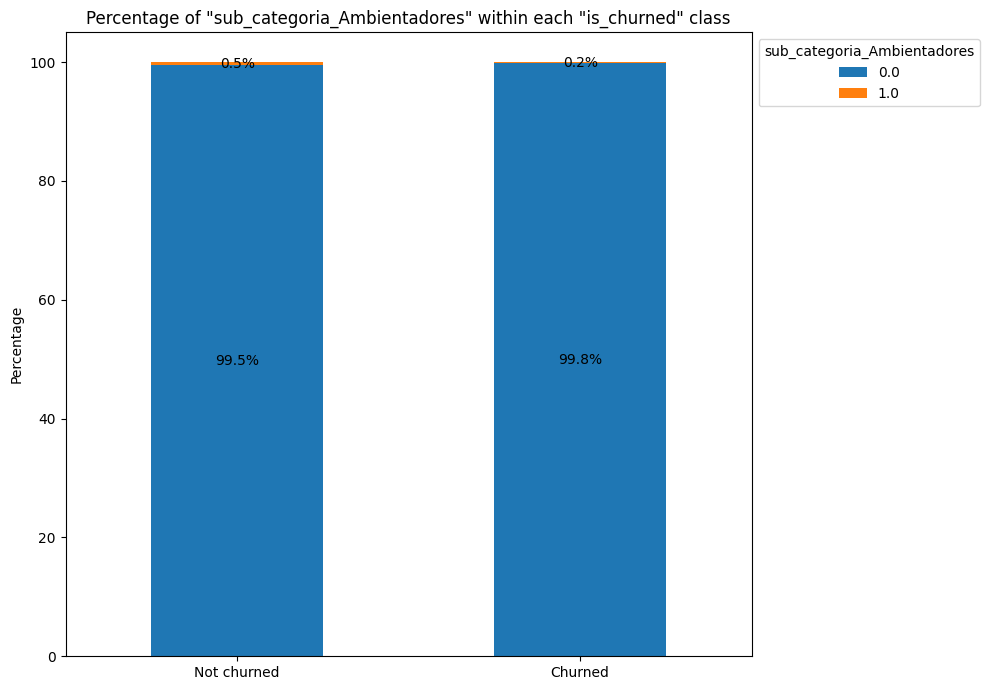

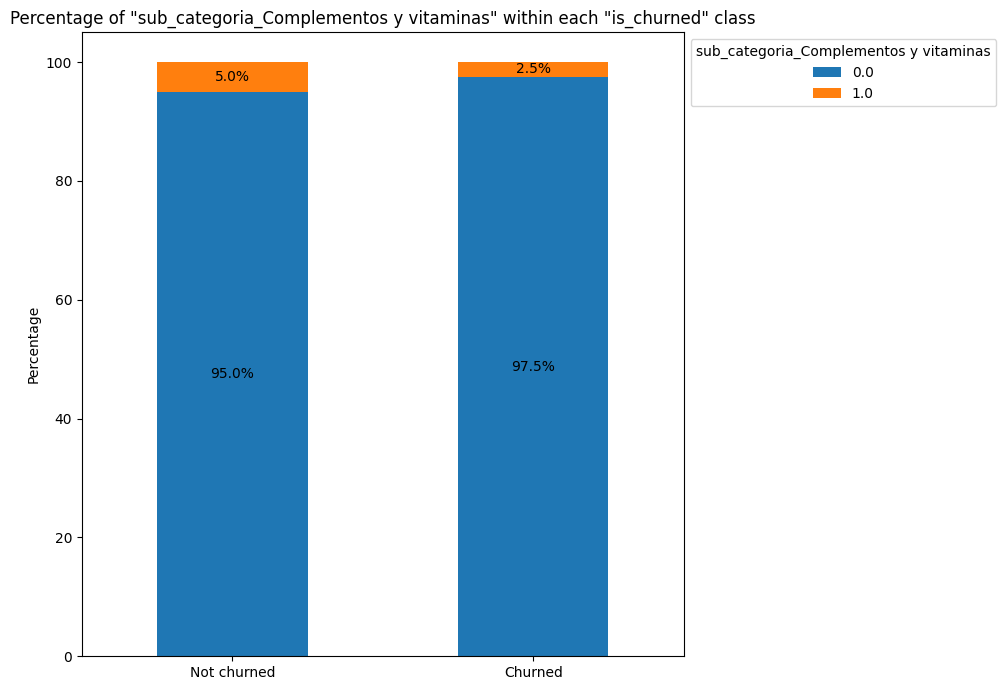

In [104]:
def compare_with_is_churned(df, variable):
    # Crear una tabla pivote para obtener los conteos
    pivot_table = df.groupby(['is_churned', variable]).size().unstack().fillna(0)

    # Calcular los porcentajes
    pivot_table_percentage = pivot_table.divide(pivot_table.sum(axis=1), axis=0) * 100

    # Crear el gráfico
    ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(10, 7))
    ax.set_xticklabels(['Not churned', 'Churned'], rotation=0)
    ax.set_xlabel('')
    plt.title(f'Percentage of "{variable}" within each "is_churned" class')
    plt.ylabel('Percentage')
    plt.legend(title=variable, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    # Anotar los porcentajes en las barras
    for n, x in enumerate([0, 1]): # Assuming 'is_churned' has two classes, 0 and 1
        for (percentage, y) in zip(pivot_table_percentage.loc[x], pivot_table_percentage.loc[x].cumsum()):
            ax.text(n, y - (percentage / 2), f'{percentage:.1f}%', ha='center', va='center')

    plt.show()

# Iterar sobre todas las columnas excepto 'is_churned'
for column in ['warehouse_Bogota', 'sub_categoria_Ambientadores', 'sub_categoria_Complementos y vitaminas']:
    if column != 'is_churned':
        compare_with_is_churned(df_reduction, column)

Interpretaciones:

- Se puede observar entonces una diferencia significativa en la proporción de la variable warehouse_bogota entre las clases de la variable objetivo 'is_churned'

- No siendo así con la variable sub_categoria_ambientadores, cuya proporción varía mucho entre cada clase de la variable objetivo

- Para la última variable categórica 'Sub_categoria_complementos_y_vitaminas', la diferencia de proporciones en cada clase de la variable objetivo fluctúa ligeramente